In [64]:
import h5py 
import numpy as np 
from astropy.io import fits
from desispec.io import read_spectra
from desispec.io import write_spectra
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# read in GAMA-Legacy catalog
cata = Cat.GamaLegacy()
gleg = cata.Read('g15')

In [4]:
# select properties from the GAMA-Legacy catalog
redshift = gleg['gama-spec']['z']
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]
ngal = len(redshift)
print('%i galaxies total' % ngal)

63495 galaxies total


In [65]:
dir_spec = UT.dat_dir()+'spectra/gamadr3_legacydr7/'
f_spec = ''.join([dir_spec, 'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.fits'])
spec = read_spectra(f_spec)

In [6]:
# read in gleg data
fblock = h5py.File(dir_spec+'gleg.g15.darksky.seed1.exptime300.1of13blocks.hdf5', 'r')
block = {}
for g in fblock.keys():
    block[g] = {} 
    for k in fblock[g].keys(): 
        block[g][k] = fblock[g][k].value
        
magnorm_flag = block['forwardmodel']['magnorm_flag']

# read in redrock output (w/ no archetype)
zblock0 = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.redrock.fits')[1].data
# read in redrock output (w/ archetype)
zblock_arch = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.redrock.archetype.fits')[1].data
# read in redrock output (w/ updated archetype constructed using GLeg synthetic spectra)
zblock_uparch = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.redrock.uparchetype.fits')[1].data

In [62]:
z_true = block['gama-spec']['z']

# redrock w/ no archetype 
z_rr0 = zblock0['Z']
dz_1pz0 = np.abs(z_true - z_rr0)/(1.+z_true)
zwarn0 = zblock0['ZWARN']
fail0 = (dz_1pz0 > 0.003) & (zwarn0 == 0) & magnorm_flag
fail_block0 = {} 
for g in block.keys(): 
    fail_block0[g] = {}
    for k in block[g].keys():
        fail_block0[g][k] = block[g][k][fail0]
print('redrock w/ no archetype fails for %i out of %i targets' % (np.sum(fail0), np.sum(magnorm_flag)))

# redrock w/ archetype 
z_rr_arch = zblock_arch['Z']
dz_1pz_arch = np.abs(z_true - z_rr_arch)/(1.+z_true)
zwarn_arch = zblock_arch['ZWARN']
fail_arch = (dz_1pz_arch > 0.003) & (zwarn_arch == 0) & magnorm_flag
fail_block_arch = {} 
for g in block.keys(): 
    fail_block_arch[g] = {}
    for k in block[g].keys():
        fail_block_arch[g][k] = block[g][k][fail_arch]
print('redrock w/ archetype fails for %i out of %i targets' % (np.sum(fail_arch), np.sum(magnorm_flag)))

# redrock w/ updated archetype 
z_rr_uparch = zblock_uparch['Z']
dz_1pz_uparch = np.abs(z_true - z_rr_uparch)/(1.+z_true)
zwarn_uparch = zblock_uparch['ZWARN']
fail_uparch = (dz_1pz_uparch > 0.003) & (zwarn_uparch == 0) & magnorm_flag
fail_block_uparch = {} 
for g in block.keys(): 
    fail_block_uparch[g] = {}
    for k in block[g].keys():
        fail_block_uparch[g][k] = block[g][k][fail_uparch]
print('redrock w/ updated archetype fails for %i out of %i targets' % (np.sum(fail_uparch), np.sum(magnorm_flag)))

redrock w/ no archetype fails for 105 out of 4972 targets
redrock w/ archetype fails for 90 out of 4972 targets
redrock w/ updated archetype fails for 116 out of 4972 targets


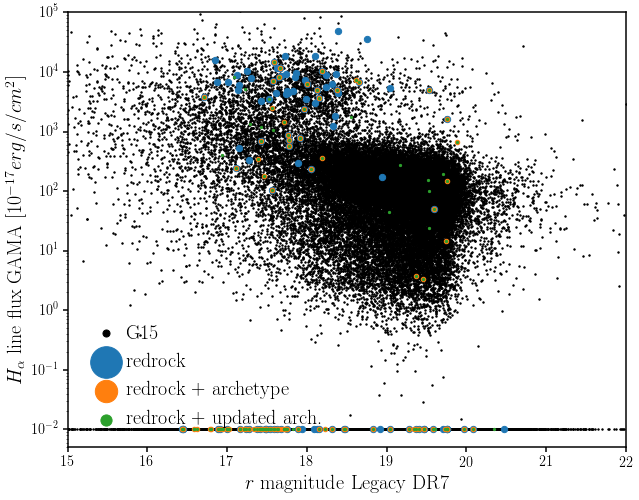

In [52]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
# entire G15 field
hasha = (gama_ha > 0)
sub.scatter(r_mag_legacy[hasha], gama_ha[hasha], s=2, c='k', label='G15')
sub.scatter(r_mag_legacy[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=2, c='k')

lbls = ['redrock', 'redrock + archetype', 'redrock + updated arch.']
sizes = [40, 20, 5]
for i_f, failblock in enumerate([fail_block0, fail_block_arch, fail_block_uparch]): 
    fail_ha = failblock['gama-spec']['ha_flux']
    fail_r_mag = UT.flux2mag(failblock['legacy-photo']['flux_r'])

    hasha = (fail_ha > 0.)
    sub.scatter(fail_r_mag[hasha], fail_ha[hasha], s=sizes[i_f], c='C'+str(i_f), label=lbls[i_f])
    sub.scatter(fail_r_mag[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=sizes[i_f], c='C'+str(i_f))
    sub.legend(loc='lower left', markerscale=5, handletextpad=0., fontsize=20)
sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([5e-3, 1e5])
sub.set_yscale('log')

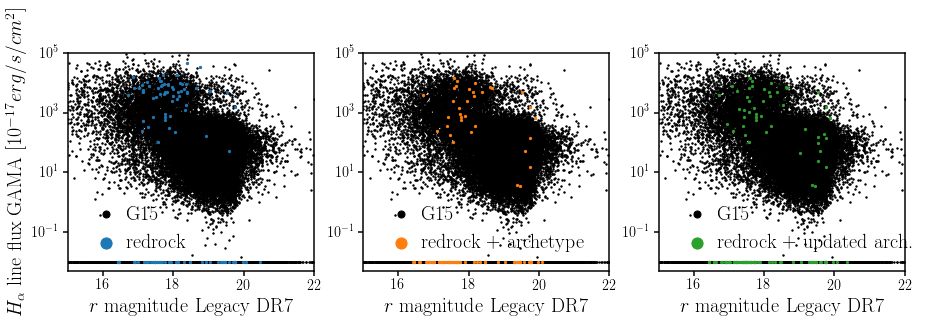

In [53]:
fig = plt.figure(figsize=(15,4))
for i_f, failblock in enumerate([fail_block0, fail_block_arch, fail_block_uparch]): 
    sub = fig.add_subplot(1,3,1+i_f)
    # entire G15 field
    hasha = (gama_ha > 0)
    sub.scatter(r_mag_legacy[hasha], gama_ha[hasha], s=2, c='k', label='G15')
    sub.scatter(r_mag_legacy[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=2, c='k')

    lbls = ['redrock', 'redrock + archetype', 'redrock + updated arch.']
    fail_ha = failblock['gama-spec']['ha_flux']
    fail_r_mag = UT.flux2mag(failblock['legacy-photo']['flux_r'])

    hasha = (fail_ha > 0.)
    sub.scatter(fail_r_mag[hasha], fail_ha[hasha], s=5, c='C'+str(i_f), label=lbls[i_f])
    sub.scatter(fail_r_mag[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=5, c='C'+str(i_f))
    sub.legend(loc='lower left', markerscale=5, handletextpad=0., fontsize=20)
    sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
    sub.set_xlim([15., 22.])
    if i_f == 0: sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([5e-3, 1e5])
    sub.set_yscale('log')

(15.0, 22.0)

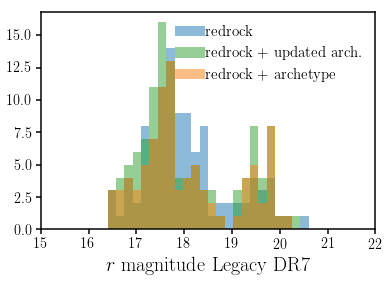

In [54]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i_f, failblock in enumerate([fail_block0, fail_block_uparch, fail_block_arch]): 
    lbls = ['redrock', 'redrock + updated arch.', 'redrock + archetype']
    colors = ['C0', 'C2', 'C1']
    fail_r_mag = UT.flux2mag(failblock['legacy-photo']['flux_r'])
    _ = sub.hist(fail_r_mag, range=(15, 22), bins=40, color=colors[i_f], alpha=0.5, label=lbls[i_f])
sub.legend(loc='upper right', handletextpad=0., fontsize=15)
sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])

(0.0, 5.0)

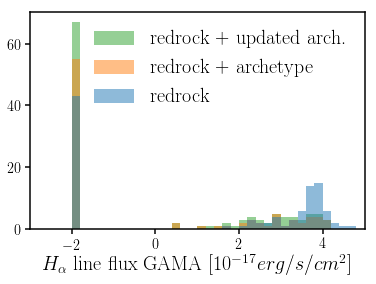

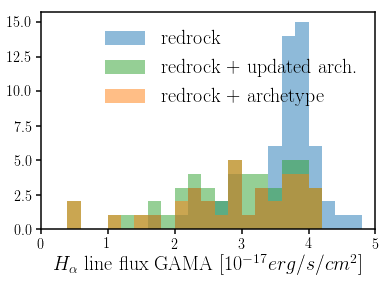

In [55]:
fig = plt.figure()
sub = fig.add_subplot(111)

for i_f, failblock in enumerate([fail_block_uparch, fail_block_arch, fail_block0]): 
    lbls = ['redrock + updated arch.', 'redrock + archetype', 'redrock']
    colors = ['C2', 'C1', 'C0']
    fail_ha = failblock['gama-spec']['ha_flux']
    hasha = (fail_ha > 0.)
    fail_has = fail_ha.copy()
    fail_has[~hasha] = 1e-2
    _ = sub.hist(np.log10(fail_has), range=(-3, 5), bins=40, color=colors[i_f], alpha=0.5, label=lbls[i_f])
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_xlim([-3., 5.])

fig = plt.figure()
sub = fig.add_subplot(111)
for i_f, failblock in enumerate([fail_block0, fail_block_uparch, fail_block_arch]): 
    lbls = ['redrock', 'redrock + updated arch.', 'redrock + archetype']
    colors = ['C0', 'C2', 'C1']
    fail_ha = failblock['gama-spec']['ha_flux']
    hasha = (fail_ha > 0.)
    _ = sub.hist(np.log10(fail_ha[hasha]), range=(-3, 5), bins=40, color=colors[i_f], alpha=0.5, label=lbls[i_f])
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_xlim([0., 5.])

In [61]:
print np.unique(zblock_arch['SUBTYPE'])
print np.unique(zblock_uparch['SUBTYPE'])

['BAL_50' 'BGS_0' 'BGS_1' 'BGS_10' 'BGS_109' 'BGS_123' 'BGS_19' 'BGS_25'
 'BGS_26' 'BGS_27' 'BGS_3' 'BGS_32' 'BGS_35' 'BGS_4' 'BGS_42' 'BGS_6'
 'BGS_62' 'BGS_67' 'BGS_7' 'BGS_75' 'BGS_94' 'BGS_95' 'ELG_104' 'ELG_106'
 'ELG_11' 'ELG_110' 'ELG_111' 'ELG_114' 'ELG_12' 'ELG_120' 'ELG_124'
 'ELG_13' 'ELG_14' 'ELG_16' 'ELG_17' 'ELG_18' 'ELG_2' 'ELG_20' 'ELG_21'
 'ELG_23' 'ELG_24' 'ELG_28' 'ELG_29' 'ELG_30' 'ELG_31' 'ELG_33' 'ELG_34'
 'ELG_36' 'ELG_39' 'ELG_41' 'ELG_44' 'ELG_49' 'ELG_5' 'ELG_50' 'ELG_54'
 'ELG_55' 'ELG_56' 'ELG_58' 'ELG_61' 'ELG_65' 'ELG_69' 'ELG_72' 'ELG_74'
 'ELG_77' 'ELG_8' 'ELG_82' 'ELG_86' 'ELG_88' 'ELG_96' 'ELG_97' 'ELG_98'
 '_10' '_11' '_13' '_18' '_2' '_20' '_21' '_22' '_35' '_4' '_42' '_48'
 '_5' '_54' '_58' '_59' '_60' '_61' '_63']
['BAL_50' 'BGS_0' 'BGS_1' 'BGS_11' 'BGS_12' 'BGS_13' 'BGS_14' 'BGS_205'
 'BGS_206' 'BGS_207' 'BGS_209' 'BGS_212' 'BGS_25' 'BGS_28' 'BGS_38'
 'BGS_4' 'BGS_6' 'BGS_72' 'BGS_77' 'BGS_8' 'BGS_82' 'BGS_9' 'ELG_10'
 'ELG_15' 'ELG_17' 'ELG_18' '